# Build Neural Linear Bandits with per-arm features

**Exploring linear and nonlinear** (e.g., those with neural network-based value functions) bandit methods for recommendations using TF-Agents

> Neural linear bandits provide a nice way to leverage the representation power of deep learning and the bandit approach for uncertainty measure and efficient exploration

## Notes

### Why generalize bandits to neural network models?

* NeuralLinear Bandits are linear contextual bandits use the last layer representation of the neural network as the contextual features
* NeuralLinear works well [paper](https://arxiv.org/pdf/1802.09127.pdf)
* Decouples representation learning and uncertainty estimation
* Computationally inexpensive 
* Achieves superior performance on multiple datasets

### Arm features

* In some bandits use cases, each arm has its own features. For example, in movie recommendation problems, the user features play the role of the context and the movies play the role of the arms (aka actions) 
* Each movie has its own features, such as `text description`, `metadata`, `trailer content` features and so on

These problems are often referred to as `arm features problems`

### Methods in this notebook:

* [global_and_arm_feature_networks](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network) to preprocess user (global) and item (per-arm) features, and output rewards
* `EncodingNetwork` to define a mapping of pre-processing layers to apply to a network's input 
* `ActorNetworks` to learn a mapping from observations to actions. These networks are usually used by our policies to generate actions

### references

**TF-Agent tutorials:**

(1) [Multi-Armed Bandits with Per-Arm Features](https://www.tensorflow.org/agents/tutorials/per_arm_bandits_tutorial)

* step-by-step guide on how to use the TF-Agents library for contextual bandits problems where the actions (arms) have their own features, such as a list of movies represented by features (genre, year of release, ...)

(2) [Networks](https://www.tensorflow.org/agents/tutorials/8_networks_tutorial)

* define custom networks for your agents
* The networks help us define the model that is trained by agents

(3) [Ranking](https://www.tensorflow.org/agents/tutorials/ranking_tutorial)

* ranking algorithms implemented as part of the TF-Agents Bandits library 
* In a ranking problem, in every iteration an agent is presented with a set of items, and is tasked with ranking some or all of them to a list
* This ranking decision then receives some form of feedback (maybe a user does or does not click on one or more of the selected items for example)
* The goal of the agent is to optimize some metric/reward with the goal of making better decisions over time

# setup notebook environment

In [2]:
import os

root_path = '/home/jupyter/tf_vertex_agents/perarm-features-bandit'
os.chdir(root_path)
os.getcwd()

'/home/jupyter/tf_vertex_agents/perarm-features-bandit'

In [3]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"

aiplatform SDK version: 1.26.0


## Load env config

* use the prefix from `00-env-setup`

In [6]:
PREFIX = 'mabv1'

In [7]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "mabv1"
VERSION                  = "v1"

BUCKET_NAME              = "mabv1-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://mabv1-hybrid-vertex-bucket/data"
BUCKET_URI               = "gs://mabv1-hybrid-vertex-bucket"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_ID      = "hybrid-vertex.movielens_dataset_mabv1"
BIGQUERY_TABLE_ID        = "hybrid-vertex.movielens_dataset_mabv1.training_dataset"

REPO_DOCKER_PATH_PREFIX  = "src"
RL_SUB_DIR               = "per_arm_rl"



In [8]:
# ! gsutil ls $BUCKET_URI
!pwd

/home/jupyter/tf_vertex_agents/perarm-features-bandit


In [9]:
# my project
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config

2023-08-02 10:43:49.038418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
data_utils.get_all_features()

{'user_id': FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'user_rating': FixedLenFeature(shape=(), dtype=tf.float32, default_value=None),
 'bucketized_user_age': FixedLenFeature(shape=(), dtype=tf.float32, default_value=None),
 'user_occupation_text': FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'timestamp': FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'movie_id': FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'movie_genres': FixedLenFeature(shape=(1,), dtype=tf.int64, default_value=None)}

## imports

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
from tf_agents.agents import TFAgent

from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network

# GPU
from numba import cuda 
import gc

# my project
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

### detect GPUs & reset devices

In [7]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
    
# gpus

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
device = cuda.get_current_device()
device.reset()
gc.collect()

23

### Initialize Google Cloud SDK Clients

In [9]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

### Read TF Records

In [10]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [11]:
train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/val'): # tmp TODO - "train"
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://mabv1-hybrid-vertex-bucket/data/val/ml-ratings-100k-val.tfrecord']

In [12]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils.parse_tfrecord)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'211'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([874948475])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'346'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'other'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


### get vocab

**TODO:** 
* streamline vocab calls

In [13]:
GENERATE_VOCABS = False
print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

VOCAB_SUBDIR   = "vocabs"
VOCAB_FILENAME = "vocab_dict.pkl"

GENERATE_VOCABS: False


In [14]:
if not GENERATE_VOCABS:

    EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'
    print(f"Downloading vocab...")
    
    os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
    print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

    filehandler = open(VOCAB_FILENAME, 'rb')
    vocab_dict = pkl.load(filehandler)
    filehandler.close()
    
    for key in vocab_dict.keys():
        pprint(key)

Downloaded vocab from: gs://mabv1-hybrid-vertex-bucket/vocabs/vocab_dict.pkl

'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


# Per-Arm Bandits

In [15]:
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

nest = tf.nest

## define preprocessing layers for global and arm features

The preproccesing layers will ultimately feed the two functions described below, both of which will ultimately feed the `Environment`

`global_context_sampling_fn`: 
* A function that outputs a random 1d array or list of ints or floats
* This output is the global context. Its shape and type must be consistent across calls.

`arm_context_sampling_fn`: 
* A function that outputs a random 1 array or list of ints or floats (same type as the output of `global_context_sampling_fn`). * This output is the per-arm context. Its shape must be consistent across calls.

In [16]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 4
MV_EMBEDDING_SIZE      = 8 #32

### global preprcoessing layers

In [18]:
# global_inputs = []
# global_features = []

#### user ID

In [17]:
user_id_input_layer = tf.keras.Input(
    name="user_id",
    shape=(1,),
    dtype=tf.string
)

user_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_id'],
)(user_id_input_layer)

user_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_id_lookup)

user_id_embedding = tf.reduce_sum(user_id_embedding, axis=-2)

# global_inputs.append(user_id_input_layer)
# global_features.append(user_id_embedding)

In [18]:
test_user_id_model = tf.keras.Model(inputs=user_id_input_layer, outputs=user_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["user_id"])
    print(test_user_id_model(x["user_id"]))

tf.Tensor([b'346'], shape=(1,), dtype=string)
tf.Tensor([[ 0.03553034 -0.04517125 -0.04602809 -0.00308038]], shape=(1, 4), dtype=float32)


#### user AGE

In [19]:
user_age_input_layer = tf.keras.Input(
    name="bucketized_user_age",
    shape=(1,),
    dtype=tf.float32
)

user_age_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['bucketized_user_age'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(user_age_input_layer)

user_age_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['bucketized_user_age']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_age_lookup)

user_age_embedding = tf.reduce_sum(user_age_embedding, axis=-2)

# global_inputs.append(user_age_input_layer)
# global_features.append(user_age_embedding)

In [20]:
test_user_age_model = tf.keras.Model(inputs=user_age_input_layer, outputs=user_age_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["bucketized_user_age"])
    print(test_user_age_model(x["bucketized_user_age"]))

tf.Tensor([25.], shape=(1,), dtype=float32)
tf.Tensor([[ 0.00416161  0.04503259  0.00331594 -0.02553109]], shape=(1, 4), dtype=float32)


#### user OCC

In [33]:
user_occ_input_layer = tf.keras.Input(
    name="user_occupation_text",
    shape=(1,),
    dtype=tf.string
)

user_occ_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_occupation_text'],
)(user_occ_input_layer)

user_occ_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_occ_lookup)

user_occ_embedding = tf.reduce_sum(user_occ_embedding, axis=-2)

# global_inputs.append(user_occ_input_layer)
# global_features.append(user_occ_embedding)

In [34]:
test_user_occ_model = tf.keras.Model(inputs=user_occ_input_layer, outputs=user_occ_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["user_occupation_text"])
    print(test_user_occ_model(x["user_occupation_text"]))

tf.Tensor([b'other'], shape=(1,), dtype=string)
tf.Tensor([[-0.00288241  0.00816492 -0.02777749  0.02080983]], shape=(1, 4), dtype=float32)


#### user Timestamp

In [23]:
user_ts_input_layer = tf.keras.Input(
    name="timestamp",
    shape=(1,),
    dtype=tf.int64
)

user_ts_lookup = tf.keras.layers.Discretization(
    vocab_dict['timestamp_buckets'].tolist()
)(user_ts_input_layer)

user_ts_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['timestamp_buckets'].tolist()) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_ts_lookup)

user_ts_embedding = tf.reduce_sum(user_ts_embedding, axis=-2)

# global_inputs.append(user_ts_input_layer)
# global_features.append(user_ts_embedding)

In [24]:
test_user_ts_model = tf.keras.Model(inputs=user_ts_input_layer, outputs=user_ts_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["timestamp"])
    print(test_user_ts_model(x["timestamp"]))

tf.Tensor([874948475], shape=(1,), dtype=int64)
tf.Tensor([[ 0.04844313 -0.03526577 -0.03514949 -0.03082577]], shape=(1, 4), dtype=float32)


### create `global_context_sampling_fn()`

In [35]:
def global_context_sampling_fn():
    """
    This function generates a single global observation vector.
    """
    # for x in train_dataset.take(1).as_numpy_iterator():
    for x in train_dataset.batch(1).take(1):
        user_id_value = x['user_id']
        user_age_value = x['bucketized_user_age']
        user_occ_value = x['user_occupation_text']
        user_ts_value = x['timestamp']
        
        _id = test_user_id_model(user_id_value)
        _age = test_user_age_model(user_age_value)
        _occ = test_user_occ_model(user_occ_value)
        _ts = test_user_ts_model(user_ts_value)
        
        # # tmp - insepct numpy() values
        # print(_id.numpy()) #[0])
        # print(_age.numpy()) #[0])
        # print(_occ.numpy()) #[0])
        # print(_ts.numpy()) #[0])
        
        # to numpy array
        _id = np.array(_id.numpy()[0])
        _age = np.array(_age.numpy()[0])
        _occ = np.array(_occ.numpy()[0])
        _ts = np.array(_ts.numpy()[0])
        
        concat = np.concatenate(
            [_id, _age, _occ, _ts], axis=-1
        ).astype(np.float32)
        
        return concat

In [36]:
global_context_sampling_fn()

array([ 0.03553034, -0.04517125, -0.04602809, -0.00308038,  0.00416161,
        0.04503259,  0.00331594, -0.02553109, -0.00288241,  0.00816492,
       -0.02777749,  0.02080983,  0.04844313, -0.03526577, -0.03514949,
       -0.03082577], dtype=float32)

In [37]:
GLOBAL_DIM = 40
GLOBAL_BOUND = 10

def test_global_context_sampling_fn():
    """This function generates a single global observation vector."""
    return np.random.randint(
      -GLOBAL_BOUND, GLOBAL_BOUND, [GLOBAL_DIM]).astype(np.float32)

In [38]:
test_global_context_sampling_fn()

array([ -4.,  -7.,  -7.,  -8.,  -9.,   7.,  -9.,  -8.,  -7.,   5.,  -8.,
         0.,   8.,  -3.,  -6.,   5.,   4.,   3.,  -3.,   5.,  -3.,   5.,
        -8.,   5.,  -6., -10.,   6.,  -3.,   1.,   8., -10., -10.,  -7.,
         8., -10.,  -5.,   4.,   5.,   3.,   7.], dtype=float32)

### arm preprocessing layers

#### movie ID

In [39]:
mv_id_input_layer = tf.keras.Input(
    name="movie_id",
    shape=(1,),
    dtype=tf.string
)

mv_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['movie_id'],
)(mv_id_input_layer)

mv_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_id_lookup)

mv_id_embedding = tf.reduce_sum(mv_id_embedding, axis=-2)

# arm_inputs.append(mv_id_input_layer)
# arm_features.append(mv_id_embedding)

In [40]:
test_mv_id_model = tf.keras.Model(inputs=mv_id_input_layer, outputs=mv_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["movie_id"])
    print(test_mv_id_model(x["movie_id"]))

tf.Tensor([b'211'], shape=(1,), dtype=string)
tf.Tensor(
[[-0.03484925 -0.02272609  0.04231134  0.00599066 -0.00476788 -0.01201147
   0.044662   -0.01274878]], shape=(1, 8), dtype=float32)


#### movie genre

In [41]:
mv_genre_input_layer = tf.keras.Input(
    name="movie_genres",
    shape=(1,),
    dtype=tf.float32
)

mv_genre_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_genres'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(mv_genre_input_layer)

mv_genre_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_genres']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_genre_lookup)

mv_genre_embedding = tf.reduce_sum(mv_genre_embedding, axis=-2)

# arm_inputs.append(mv_genre_input_layer)
# arm_features.append(mv_genre_embedding)

In [42]:
test_mv_gen_model = tf.keras.Model(inputs=mv_genre_input_layer, outputs=mv_genre_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["movie_genres"])
    print(test_mv_gen_model(x["movie_genres"]))

tf.Tensor([[4]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[ 0.03335417 -0.04220902 -0.01734512  0.0391299   0.04903633  0.01076964
   0.00245056 -0.02346447]], shape=(1, 8), dtype=float32)


### create `arm_context_sampling_fn()`

In [43]:
def per_arm_context_sampling_fn():
    """
    This function generates a single per-arm observation vector
    """
    for x in train_dataset.batch(1).take(1):
        mv_id_value = x['movie_id']
        mv_gen_value = x['movie_genres'][0]
        
        _mid = test_mv_id_model(mv_id_value)
        _mgen = test_mv_gen_model(mv_gen_value)
        
        # to numpy array
        _mid = np.array(_mid.numpy()[0])
        _mgen = np.array(_mgen.numpy()[0])
        
        # print(_mid)
        # print(_mgen)
        
        concat = np.concatenate([_mid, _mgen], axis=-1).astype(np.float32)
        
        return concat

In [44]:
per_arm_context_sampling_fn()

array([-0.03484925, -0.02272609,  0.04231134,  0.00599066, -0.00476788,
       -0.01201147,  0.044662  , -0.01274878,  0.03335417, -0.04220902,
       -0.01734512,  0.0391299 ,  0.04903633,  0.01076964,  0.00245056,
       -0.02346447], dtype=float32)

## define reward function

In [45]:
GLOBAL_DIM = global_context_sampling_fn()
GLOBAL_DIM = GLOBAL_DIM.shape[0]
print(GLOBAL_DIM)

PER_ARM_DIM = per_arm_context_sampling_fn()
PER_ARM_DIM = PER_ARM_DIM.shape[0]
print(PER_ARM_DIM)

16
16


In [51]:
PARAM_BOUND = 5 

# should be similar to
reward_param = list(np.random.randint(-PARAM_BOUND, PARAM_BOUND, [GLOBAL_DIM + PER_ARM_DIM]))
# reward_param

In [52]:
print(len(reward_param))
# reward_param

32


In [53]:
test_global_out = global_context_sampling_fn()
test_arm_out = per_arm_context_sampling_fn()

x_x = np.concatenate([test_global_out, test_arm_out], axis=-1)
# x_x
mu = np.dot(x_x, reward_param)
mu

0.5994267016649246

In [54]:
VARIANCE = 100.0 

def linear_normal_reward_fn(x):
    """This function generates a reward from the concatenated global and per-arm observations."""
    mu = np.dot(x, reward_param)
    return np.random.normal(mu, VARIANCE)

In [55]:
linear_normal_reward_fn(x_x)

-169.7490711991688

In [56]:
# def _get_rewards(element):
#     """Calculates reward for the actions."""

#     def _calc_reward(x):
#         """Calculates reward for a single action."""
#         r0 = lambda: tf.constant(0.0)
#         r1 = lambda: tf.constant(-10.0)
#         r2 = lambda: tf.constant(2.0)
#         r3 = lambda: tf.constant(3.0)
#         r4 = lambda: tf.constant(4.0)
#         r5 = lambda: tf.constant(10.0)
#         c1 = tf.equal(x, 1.0)
#         c2 = tf.equal(x, 2.0)
#         c3 = tf.equal(x, 3.0)
#         c4 = tf.equal(x, 4.0)
#         c5 = tf.equal(x, 5.0)
#         return tf.case([(c1, r1), (c2, r2), (c3, r3),(c4, r4),(c5, r5)], default=r0, exclusive=True)

#     return tf.map_fn(
#         fn=_calc_reward, 
#         elems=element['user_rating'], 
#         dtype=tf.float32
#     )

In [57]:
# for x in train_dataset.batch(1).take(3):
#     print(f"Rating: {x['user_rating']}")
#     print(f"Reward: {_get_rewards(x)}") #["user_rating"]))

# ## output ####
# Rating: [4.]
# Reward: [4.]
# Rating: [4.]
# Reward: [4.]
# Rating: [1.]
# Reward: [-10.]

## define environment

`num_actions_fn`:
* a function that outputs a single integer specifying the number of actions for a given time step. 
* The number of actions will be encoded in the observation by the feature key `num_actions`

In [58]:
NUM_ACTIONS = 10
BATCH_SIZE = 20

# num_actions_fn = None
num_actions_fn = lambda: NUM_ACTIONS

In [59]:
per_arm_py_env = p_a_env.StationaryStochasticPerArmPyEnvironment(
    global_context_sampling_fn = global_context_sampling_fn,
    arm_context_sampling_fn = per_arm_context_sampling_fn,
    max_num_actions = NUM_ACTIONS,
    reward_fn = linear_normal_reward_fn, # _get_rewards
    num_actions_fn = num_actions_fn,
    batch_size=BATCH_SIZE
)
per_arm_tf_env = tf_py_environment.TFPyEnvironment(per_arm_py_env)

In [60]:
print('observation spec: ', per_arm_tf_env.observation_spec())

observation spec:  {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 16), dtype=tf.float32, name=None), 'num_actions': BoundedTensorSpec(shape=(), dtype=tf.int64, name=None, minimum=array(1), maximum=array(10))}


In [61]:
print('reward_spec: ', per_arm_tf_env.reward_spec())

reward_spec:  TensorSpec(shape=(), dtype=tf.float32, name='reward')


In [62]:
print('\nAn observation: ', per_arm_tf_env.reset().observation)


An observation:  {'global': <tf.Tensor: shape=(20, 16), dtype=float32, numpy=
array([[ 0.03553034, -0.04517125, -0.04602809, -0.00308038,  0.00416161,
         0.04503259,  0.00331594, -0.02553109, -0.00288241,  0.00816492,
        -0.02777749,  0.02080983,  0.04844313, -0.03526577, -0.03514949,
        -0.03082577],
       [ 0.03553034, -0.04517125, -0.04602809, -0.00308038,  0.00416161,
         0.04503259,  0.00331594, -0.02553109, -0.00288241,  0.00816492,
        -0.02777749,  0.02080983,  0.04844313, -0.03526577, -0.03514949,
        -0.03082577],
       [ 0.03553034, -0.04517125, -0.04602809, -0.00308038,  0.00416161,
         0.04503259,  0.00331594, -0.02553109, -0.00288241,  0.00816492,
        -0.02777749,  0.02080983,  0.04844313, -0.03526577, -0.03514949,
        -0.03082577],
       [ 0.03553034, -0.04517125, -0.04602809, -0.00308038,  0.00416161,
         0.04503259,  0.00331594, -0.02553109, -0.00288241,  0.00816492,
        -0.02777749,  0.02080983,  0.04844313, -0.03

In [63]:
action = tf.zeros(BATCH_SIZE, dtype=tf.int32)
time_step = per_arm_tf_env.step(action)
print('\nRewards after taking an action: ', time_step.reward)


Rewards after taking an action:  tf.Tensor(
[ 136.47661   226.3307     29.882029 -134.32669   118.55546   190.43375
   40.61807   -20.627342   87.61966    18.61068   -43.170372 -161.87923
   54.986633  -54.7642     38.154198  159.64062   180.57867    20.324299
   75.80213    15.043438], shape=(20,), dtype=float32)


## The Agent

**Note** that contextual bandits form a special case of RL, where the actions taken by the agent do not alter the state of the environment 

> “Contextual” refers to the fact that the agent chooses among a set of actions while having knowledge of the context (environment observation)

### agent types

**Possible Agent Types:**

```
AGENT_TYPE = ['LinUCB', 'LinTS', 'epsGreedy', 'NeuralLinUCB']
```

**LinearUCBAgent:** (`LinUCB`)
* An agent implementing the Linear UCB bandit algorithm
* (whitepaper) [A contextual bandit approach to personalized news recommendation](https://arxiv.org/abs/1003.0146)
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/lin_ucb_agent/LinearUCBAgent)

**LinearThompsonSamplingAgent:** (`LinTS`)
* Implements the Linear Thompson Sampling Agent from the paper: [Thompson Sampling for Contextual Bandits with Linear Payoffs](https://arxiv.org/abs/1209.3352)
* the agent maintains two parameters `weight_covariances` and `parameter_estimators`, and updates them based on experience.
* The inverse of the weight covariance parameters are updated with the outer product of the observations using the Woodbury inverse matrix update, while the parameter estimators are updated by the reward-weighted observation vectors for every action
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/linear_thompson_sampling_agent/LinearThompsonSamplingAgent)

**NeuralEpsilonGreedyAgent:** (`epsGreedy`) 
* A neural network based epsilon greedy agent
* This agent receives a neural network that it trains to predict rewards
* The action is chosen greedily with respect to the prediction with probability `1 - epsilon`, and uniformly randomly with probability epsilon
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_epsilon_greedy_agent/NeuralEpsilonGreedyAgent)

**NeuralLinUCBAgent:** (`NeuralLinUCB`)
* An agent implementing the LinUCB algorithm on top of a neural network
* `ENCODING_DIM` is the output dimension of the encoding network 
> * This output will be used by either a linear reward layer and epsilon greedy exploration, or by a LinUCB logic, depending on the number of training steps executed so far
* `EPS_PHASE_STEPS` is the number training steps to run for training the encoding network before switching to `LinUCB`
> * If negative, the encoding network is assumed to be already trained
> * If the number of steps is less than or equal to `EPS_PHASE_STEPS`, `epsilon greedy` is used, otherwise `LinUCB`
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_linucb_agent/NeuralLinUCBAgent)

### network types

Which network architecture to use for the `epsGreedy` or `NeuralLinUCB` agents

```
NETWORK_TYPE = ['commontower', 'dotproduct']
```

**GlobalAndArmCommonTowerNetwork:** (`commontower`)
* This network takes the output of the global and per-arm networks, and leads them through a common network, that in turn outputs reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
> * `COMMON_LAYERS` - Iterable of ints. Specifies the layers of the common tower
* The network produced by this function can be used either in `GreedyRewardPredictionPolicy`, or `NeuralLinUCBPolicy`
> * In the former case, the network must have `output_dim=1`, it is going to be an instance of `QNetwork`, and used in the policy as a reward prediction network
> * In the latter case, the network will be an encoding network with its output consumed by a reward layer or a `LinUCB` method. The specified `output_dim` will be the encoding dimension
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmCommonTowerNetwork)

**GlobalAndArmDotProductNetwork:** (`dotproduct`)
* This network calculates the **dot product** of the output of the global and per-arm networks and returns them as reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmDotProductNetwork)

### define agent and network (optional)

In [65]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 5
EPS_PHASE_STEPS = 1000

# ================================
# Agent's Preprocess Network
# ================================
NETWORK_TYPE    = "dotproduct" # 'commontower' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    

GLOBAL_LAYERS   = [16, 4]
ARM_LAYERS      = [16, 4]
COMMON_LAYERS   = [4]

observation_and_action_constraint_splitter = None

print(f"AGENT_TYPE      : {AGENT_TYPE}")
print(f"NETWORK_TYPE    : {NETWORK_TYPE}")
print(f"AGENT_ALPHA     : {AGENT_ALPHA}")
print(f"EPSILON         : {EPSILON}")
print(f"LR              : {LR}")
print(f"ENCODING_DIM    : {ENCODING_DIM}")
print(f"EPS_PHASE_STEPS : {EPS_PHASE_STEPS}")
print(f"GLOBAL_LAYERS   : {GLOBAL_LAYERS}")
print(f"ARM_LAYERS      : {ARM_LAYERS}")
print(f"COMMON_LAYERS   : {COMMON_LAYERS}")

AGENT_TYPE      : epsGreedy
NETWORK_TYPE    : dotproduct
AGENT_ALPHA     : 0.1
EPSILON         : 0.01
LR              : 0.05
ENCODING_DIM    : 5
EPS_PHASE_STEPS : 1000
GLOBAL_LAYERS   : [16, 4]
ARM_LAYERS      : [16, 4]
COMMON_LAYERS   : [4]


In [66]:
from tf_agents.bandits.policies import policy_utilities

network = None

if AGENT_TYPE == 'LinUCB':
    agent = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=per_arm_tf_env.time_step_spec(),
        action_spec=per_arm_tf_env.action_spec(),
        alpha=AGENT_ALPHA,
        accepts_per_arm_features=True,
        dtype=tf.float32,
    )
elif AGENT_TYPE == 'LinTS':
    agent = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=per_arm_tf_env.time_step_spec(),
        action_spec=per_arm_tf_env.action_spec(),
        alpha=AGENT_ALPHA,
        observation_and_action_constraint_splitter=(
            observation_and_action_constraint_splitter
        ),
        accepts_per_arm_features=True,
        dtype=tf.float32,
    )
elif AGENT_TYPE == 'epsGreedy':
    obs_spec = per_arm_tf_env.observation_spec()
    if NETWORK_TYPE == 'commontower':
        network = global_and_arm_feature_network.create_feed_forward_common_tower_network(
            observation_spec = obs_spec, 
            global_layers = GLOBAL_LAYERS, 
            arm_layers = ARM_LAYERS, 
            common_layers = COMMON_LAYERS,
            # output_dim = 1
        )
    elif NETWORK_TYPE == 'dotproduct':
        network = global_and_arm_feature_network.create_feed_forward_dot_product_network(
            observation_spec = obs_spec, 
            global_layers = GLOBAL_LAYERS, 
            arm_layers = ARM_LAYERS
        )
    agent = neural_epsilon_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=per_arm_tf_env.time_step_spec(),
        action_spec=per_arm_tf_env.action_spec(),
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        epsilon=EPSILON,
        observation_and_action_constraint_splitter=(
            observation_and_action_constraint_splitter
        ),
        accepts_per_arm_features=True,
        emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
    )

elif AGENT_TYPE == 'NeuralLinUCB':
    obs_spec = per_arm_tf_env.observation_spec()
    network = (
        global_and_arm_feature_network.create_feed_forward_common_tower_network(
            observation_spec = obs_spec, 
            global_layers = GLOBAL_LAYERS, 
            arm_layers = ARM_LAYERS, 
            common_layers = COMMON_LAYERS,
            output_dim = ENCODING_DIM
        )
    )
    agent = neural_linucb_agent.NeuralLinUCBAgent(
        time_step_spec=per_arm_tf_env.time_step_spec(),
        action_spec=per_arm_tf_env.action_spec(),
        encoding_network=network,
        encoding_network_num_train_steps=EPS_PHASE_STEPS,
        encoding_dim=ENCODING_DIM,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        alpha=1.0,
        gamma=1.0,
        epsilon_greedy=EPSILON,
        accepts_per_arm_features=True,
        debug_summaries=True,
        summarize_grads_and_vars=True,
        emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
    )
    
print(f"Agent: {agent.name}\n")

if network:
    print(f"Network: {network.name}")

Agent: neural_epsilon_greedy_agent

Network: GlobalAndArmDotProductNetwork


In [67]:
pprint(agent.policy.trajectory_spec)

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 16), dtype=tf.float32, name=None), 'num_actions': BoundedTensorSpec(shape=(), dtype=tf.int64, name=None, minimum=array(1), maximum=array(10))}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(10,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'rewa

In [55]:
# observation_spec = per_arm_tf_env.observation_spec()
# time_step_spec = ts.time_step_spec(observation_spec)
# time_step_spec

In [56]:
# action_spec = tensor_spec.BoundedTensorSpec(
#     dtype=tf.int32, shape=(), minimum=0, maximum=NUM_ACTIONS - 1)

# action_spec

In [57]:
# agent = lin_ucb_agent.LinearUCBAgent(
#     time_step_spec=time_step_spec,
#     action_spec=action_spec,
#     accepts_per_arm_features=True
# )

# agent

## The flow of training data

In [68]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'num_actions': BoundedTensorSpec(shape=(), dtype=tf.int64, name=None, minimum=array(1), maximum=array(10))}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(10,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 

In [69]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'num_actions': BoundedTensorSpec(shape=(), dtype=tf.int64, name=None, minimum=array(1), maximum=array(10))}


In [70]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(16,), dtype=tf.float32, name=None)


## Defining the Regret Metric

In [87]:
def _all_rewards(observation, hidden_param):
    """Outputs rewards for all actions, given an observation."""
    hidden_param = tf.cast(hidden_param, dtype=tf.float32)
    global_obs = observation['global']
    per_arm_obs = observation['per_arm']
    num_actions = tf.shape(per_arm_obs)[1]
    tiled_global = tf.tile(
        tf.expand_dims(global_obs, axis=1), [1, num_actions, 1])
    concatenated = tf.concat([tiled_global, per_arm_obs], axis=-1)
    rewards = tf.linalg.matvec(concatenated, hidden_param)
    return rewards

def optimal_reward(observation, hidden_param):
    """Outputs the maximum expected reward for every element in the batch."""
    return tf.reduce_max(
        _all_rewards(observation, hidden_param), axis=1
    )

def optimal_action(observation, hidden_param):
    return tf.argmax(
        _all_rewards(observation, hidden_param), axis=1, output_type=tf.int32
    )

# works
# regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward)

# new
optimal_reward_fn = functools.partial(
    optimal_reward, hidden_param=reward_param
)
optimal_action_fn = functools.partial(
    optimal_action, hidden_param=reward_param
)

suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
    optimal_action_fn
)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)

metrics = [regret_metric, suboptimal_arms_metric]

## Training Loop

* train stationary env [example](https://github.com/418sec/agents/blob/master/tf_agents/bandits/agents/examples/v2/train_eval_per_arm_stationary_linear.py)
* train loop [src](https://github.com/418sec/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py)

`async_steps_per_loop`: 
* an optional integer for simulating offline or asynchronous training
* In each training loop iteration, the driver runs this many times, each executing `steps_per_loop` driver steps, and then the agent gets asynchronously trained over this many batches sampled from the replay buffer
* When unset or set to 1, the function performs synchronous training, where the agent gets trained on a single batch immediately after the driver runs.


**TODO**
* add checkpointer
* add ditribution strategy (GPU support)

In [88]:
from tf_agents.bandits.agents.examples.v2 import trainer

In [89]:
EXPERIMENT_NAME   = f'neural-linear-bandits-v1'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

LOG_DIR           = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/tb-logs"
ROOT_DIR          = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : neural-linear-bandits-v1
RUN_NAME          : run-20230801-230947
LOG_DIR           : gs://mabv1-hybrid-vertex-bucket/neural-linear-bandits-v1/run-20230801-230947/tb-logs
ROOT_DIR          : gs://mabv1-hybrid-vertex-bucket/neural-linear-bandits-v1/run-20230801-230947/root
ARTIFACTS_DIR     : gs://mabv1-hybrid-vertex-bucket/neural-linear-bandits-v1/run-20230801-230947/artifacts


In [90]:
import tensorflow as tf
from tf_agents.metrics import tf_metrics

from src.per_arm_rl import trainer_common as trainer_common

TRAINING_LOOPS = 50
STEPS_PER_LOOP = 2
drop_arm_feature_fn = None
ASYNC_STEPS_PER_LOOP = 1

In [65]:

# put these in trainer_common.py

# replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
#     data_spec=agent.policy.trajectory_spec,
#     batch_size=BATCH_SIZE,
#     max_length=STEPS_PER_LOOP * ASYNC_STEPS_PER_LOOP
# )

# # `step_metric` records the number of individual rounds of bandit interaction;
# # that is, (number of trajectories) * batch_size.
# step_metric = tf_metrics.EnvironmentSteps()

# observers = [replay_buffer.add_batch, regret_metric, step_metric, suboptimal_arms_metric]

# driver = dynamic_step_driver.DynamicStepDriver(
#     env=per_arm_tf_env,
#     policy=agent.collect_policy,
#     num_steps=STEPS_PER_LOOP * BATCH_SIZE,
#     observers=observers
# )

In [ ]:
#start the timer and training
start_time = time.time()

metric_results = trainer_common.train_perarm(
    agent = agent,
    # replay_buffer = replay_buffer,
    # driver = driver,
    environment = per_arm_tf_env,
    # step_metric = step_metric,
    num_iterations = TRAINING_LOOPS,
    steps_per_loop = STEPS_PER_LOOP,
    log_interval = 1,
    # regret_metric = regret_metric,
    log_dir=LOG_DIR,
    model_dir=ARTIFACTS_DIR,
    root_dir=ROOT_DIR,
    async_steps_per_loop = ASYNC_STEPS_PER_LOOP,
    resume_training_loops = False,
    get_replay_buffer_fn = None,
    get_training_loop_fn = None,
    training_data_spec_transformation_fn = None,
    additional_metrics = metrics
)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

setting checkpoint_manager: gs://mabv1-hybrid-vertex-bucket/neural-linear-bandits-v1/run-20230729-140822/root/chkpoint
starting_loop: 0
starting train loop...
step = 0: loss = 11196.7998046875; execution time: 1
step = 1: loss = 11192.3095703125; execution time: 1
step = 2: loss = 11986.1103515625; execution time: 1
step = 3: loss = 9114.740234375; execution time: 1
step = 4: loss = 13613.1298828125; execution time: 1
step = 5: loss = 7425.06005859375; execution time: 1
step = 6: loss = 5857.77978515625; execution time: 0


### bandit eval

In [568]:
# len(metric_results['RegretMetric'])
# metric_results

In [598]:
for key in metric_results:
    print(key)

NumberOfEpisodes
AverageEpisodeLengthMetric
RegretMetric
SuboptimalArmsMetric
AverageReturnMetric


In [599]:
def plot(metric_results, metric_name):
    plt.plot(metric_results[metric_name])
    plt.ylabel(metric_name)
    plt.xlabel("Step")
    plt.title("{} versus Step".format(metric_name))

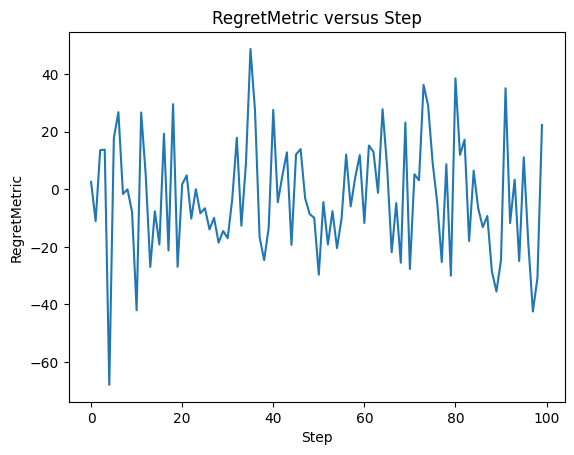

In [600]:
plot(metric_results, "RegretMetric")

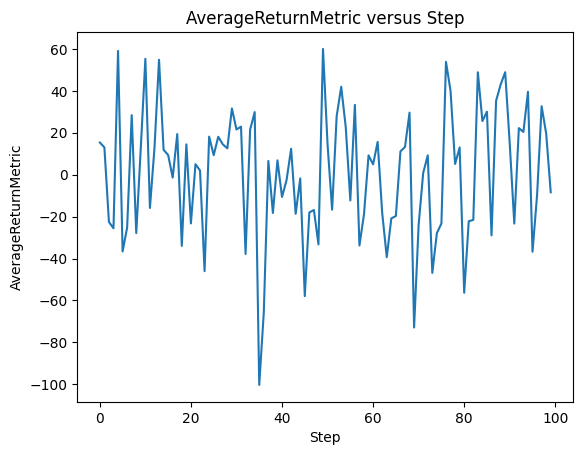

In [601]:
plot(metric_results, "AverageReturnMetric")

#### TensorBoard

In [602]:
# %load_ext tensorboard
%reload_ext tensorboard

In [603]:
%tensorboard --logdir=$LOG_DIR

### log experiment to Vertex

In [604]:
if not network:
    NETWORK_NAME = "None"
    GLOBAL_LAYERS = "None"
    ARM_LAYERS = "None"
    COMMON_LAYERS = "None"
    ENCODING_DIM = "None"
    EPS_PHASE_STEPS = "None"
else:
    NETWORK_NAME = network.name
    GLOBAL_LAYERS = GLOBAL_LAYERS
    ARM_LAYERS = ARM_LAYERS
    COMMON_LAYERS = COMMON_LAYERS
    ENCODING_DIM = ENCODING_DIM
    EPS_PHASE_STEPS = EPS_PHASE_STEPS

print(f"NETWORK_NAME    : {NETWORK_NAME}")
print(f"GLOBAL_LAYERS   : {GLOBAL_LAYERS}")
print(f"ARM_LAYERS      : {ARM_LAYERS}")
print(f"COMMON_LAYERS   : {COMMON_LAYERS}")
print(f"ENCODING_DIM    : {ENCODING_DIM}")
print(f"EPS_PHASE_STEPS : {EPS_PHASE_STEPS}")

NETWORK_NAME    : GlobalAndArmDotProductNetwork
GLOBAL_LAYERS   : [16, 4]
ARM_LAYERS      : [16, 4]
COMMON_LAYERS   : [4]
ENCODING_DIM    : 5
EPS_PHASE_STEPS : 1000


In [605]:
aiplatform.start_run(
    RUN_NAME
    # , tensorboard=TB_RESOURCE_NAME
    , resume=False
)

aiplatform.log_params(
    {
        "agent_type": agent.name,
        "network": NETWORK_NAME,
        "runtime": runtime_mins,
        "batch_size": BATCH_SIZE, 
        "training_loops": TRAINING_LOOPS,
        "steps_pre_loop": STEPS_PER_LOOP,
        # "rank_k": RANK_K,
        "num_actions": NUM_ACTIONS,
        "per_arm": "True",
        "global_lyrs": str(GLOBAL_LAYERS),
        "arm_lyrs": str(ARM_LAYERS),
        "common_lyrs": str(COMMON_LAYERS),
        "encoding_dim": ENCODING_DIM,
        "eps_steps": EPS_PHASE_STEPS,
    }
)

# gather the metrics for the last epoch to be saved in metrics
aiplatform.log_metrics(
    {
        "AverageReturnMetric" : float(metric_results["AverageReturnMetric"][-1])
        , "FinalRegretMetric" : float(metric_results["RegretMetric"][-1])
    }
)

aiplatform.end_run()

# Neural Bandits

* `ActorNetwork` and `EncodingNetwork`

In [200]:
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.networks import global_and_arm_feature_network

In [201]:
LAYERS = [16, 4]
LR = 0.05
EPSILON = 0.02

In [202]:
network = (
    global_and_arm_feature_network.create_feed_forward_dot_product_network(
        per_arm_tf_env.time_step_spec().observation,
        global_layers=LAYERS,
        arm_layers=LAYERS
    )
)

In [203]:
agent = eps_greedy_agent.NeuralEpsilonGreedyAgent(
    time_step_spec=per_arm_tf_env.time_step_spec(),
    action_spec=per_arm_tf_env.action_spec(),
    reward_network=network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
    epsilon=EPSILON,
    emit_policy_info='predicted_rewards_mean',
    info_fields_to_inherit_from_greedy=['predicted_rewards_mean']
)

In [210]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 16), dtype=tf.float32, name=None)}),
 'policy_info': PolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(10,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [211]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 16), dtype=tf.float32, name=None)}


In [213]:
# print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

In [214]:
TRAINING_LOOPS=10
STEPS_PER_LOOP=1

In [215]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=per_arm_tf_env,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * BATCH_SIZE,
    observers=observers
)

regret_values = []

#start the timer and training
start_time = time.time()

for _ in range(TRAINING_LOOPS):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())
    
end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

complete train job in 1 minutes


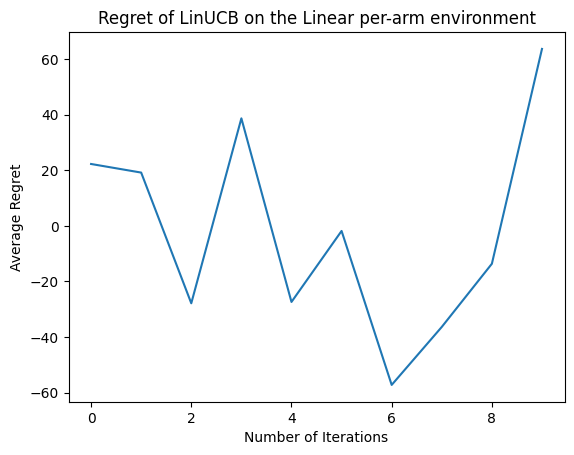

In [216]:
plt.plot(regret_values)
plt.title('Regret of LinUCB on the Linear per-arm environment')
plt.xlabel('Number of Iterations')
_ = plt.ylabel('Average Regret')

#### TODO

In [ ]:
# elif FLAGS.agent == 'NeuralLinUCB':
# obs_spec = environment.observation_spec()
# network = (
#     global_and_arm_feature_network.create_feed_forward_common_tower_network(
#         obs_spec, (40, 30), (30, 40), (40, 20), ENCODING_DIM
#     )
# )
# agent = neural_linucb_agent.NeuralLinUCBAgent(
#     time_step_spec=environment.time_step_spec(),
#     action_spec=environment.action_spec(),
#     encoding_network=network,
#     encoding_network_num_train_steps=EPS_PHASE_STEPS,
#     encoding_dim=ENCODING_DIM,
#     optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
#     alpha=1.0,
#     gamma=1.0,
#     epsilon_greedy=EPSILON,
#     accepts_per_arm_features=True,
#     debug_summaries=True,
#     summarize_grads_and_vars=True,
#     emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
# )